In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [2]:
print(plt.rcParamsDefault['figure.figsize'])

plt.rcParams = plt.rcParamsDefault

[8.0, 6.0]


In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [4]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
#something is up with the other traning sample from before not fitting the data, 
#so I'm going to try this again

#load data:
f_halo = h5py.File('../m12i_res_7100_cdm/halo/halo_600.hdf5')

pos_halo = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo = f_halo['velocity'][:]

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos = pos_halo[host_id]
host_vel = vel_halo[host_id]

f = h5py.File('../m12i_res_7100_cdm/DM_data_w_stars_training.hdf5')

dm_mass = f['PartType1']['Masses'][:]
stellar_mass = f['PartType1']['Stellar_Masses'][:]
coords = f['PartType1']['Coordinates'][:]
vel = f['PartType1']['Velocities'][:]
mass_ratio = stellar_mass/dm_mass[0]

phase_space_coords =  np.concatenate((coords-host_pos,vel-host_vel),axis=1)

non_zero_mask = (mass_ratio>0.0) #only want to train on things that are non-zero                                      

labels_non_zero = mass_ratio[non_zero_mask]
phase_space_non_zero = phase_space_coords[non_zero_mask]

f.close()

dm_mass, stellar_mass, coords, vel, mass_ratio = None,None,None,None,None

<ipython-input-5-a0f0d516c8ef>:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_halo = h5py.File('../m12i_res_7100_cdm/halo/halo_600.hdf5')
<ipython-input-5-a0f0d516c8ef>:19: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('../m12i_res_7100_cdm/DM_data_w_stars_training.hdf5')


In [6]:
#Now I need to construct my model
#I'm going to take this from a stakeabuse post

#They claim you always want to normalize your data (what does that do and why)
#They use a sklearn function called StandardScaler

#So StandardScaler changes the data such that its mean is zero and its variance is one
#This is done for each "feature"

#why?

#First test_train split

X_train, X_test, y_train, y_test = train_test_split(phase_space_non_zero, labels_non_zero,
                                                   test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [20]:
#Now I want to build my model. I still don't understand the specifics of model creation
#In that I don't know how to select the layers and nodes appropriately 

#In this tutorial it looks like they build their layers iteratively

from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

#input_layer = Input(shape=(phase_space_non_zero.shape[1],))
#dense_layer_1 = Dense(100, activation='relu')(input_layer)
#dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
#dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
#output = Dense(1)(dense_layer_3)

#input_layer = Input(shape=(phase_space_non_zero.shape[1],))
#dense_layer_1 = Dense(100, activation='relu')(input_layer)
#dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
#dense_layer_3 = Dense(25, activation='relu')(input_layer)
#output = Dense(1)(dense_layer_3)

#model = Model(inputs=input_layer,outputs=output)
#model.compile(loss="mean_squared_error",optimizer='adam',metrics=["mean_squared_error"])

#**NOTE**
#This is a linear regressor, it's not clear to me that you can even do a non-linear
#regressor with a neural network

In [17]:
#epochs = 10
#history = model.fit(X_train,y_train,batch_size=2,epochs=epochs,verbose=1,validation_split=0.2)

Epoch 1/10
343606/343606 [==============================] - 272s 791us/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 2/10
343606/343606 [==============================] - 259s 755us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 3/10
343606/343606 [==============================] - 261s 760us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 4/10
343606/343606 [==============================] - 261s 760us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 5/10
343606/343606 [==============================] - 262s 762us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 6/10
343606/343606 [==============================] - 264s 768us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0130 -

In [14]:
print(X_train.shape)
859016/1000

(859016, 6)


859.016

In [ ]:
#gonna try gaussian process from sklearn, you can do a gaussian process in TF
#but it seems super hard to parse and unintuitive

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn import preprocessing
from sklearn import utils


bg_gp = BaggingRegressor(base_estimator=GaussianProcessRegressor(),n_estimators=100,n_jobs=4
                         ,max_samples=10000,bootstrap=True,verbose=True)

bg_gp.fit(X_train,y_train)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


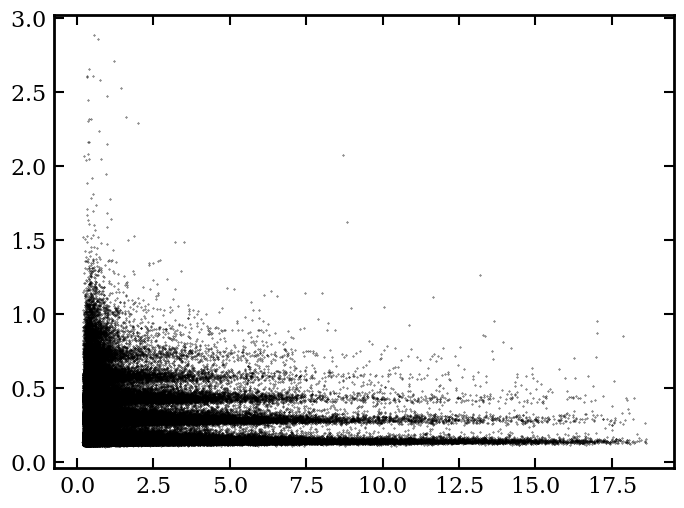

In [11]:
train_dist = np.sqrt(X_train[:,0]**2.0+X_train[:,1]**2.0+X_train[:,2]**2.0)

plt.scatter(train_dist,y_train,s=0.1,color='k')
plt.show()

In [8]:
X_train[::1000].shape


(860, 6)

In [16]:
pred_train = bg_gp.predict(X_train[::10])
pred_test = bg_gp.predict(X_test[::10])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   21.8s remaining:   21.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   22.7s finished


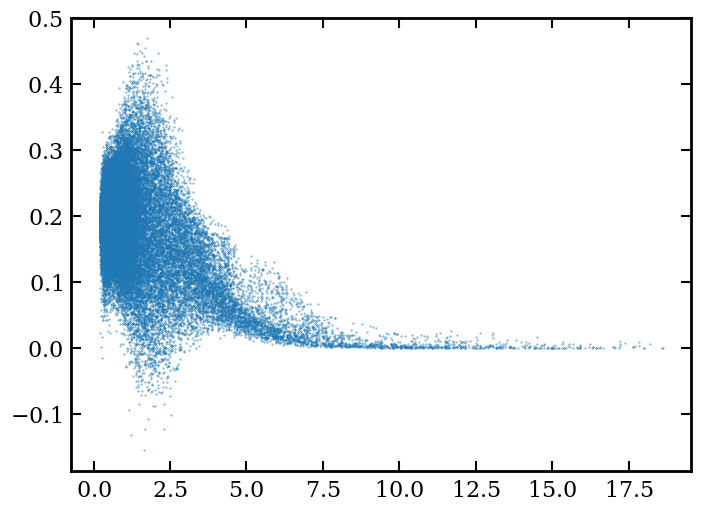

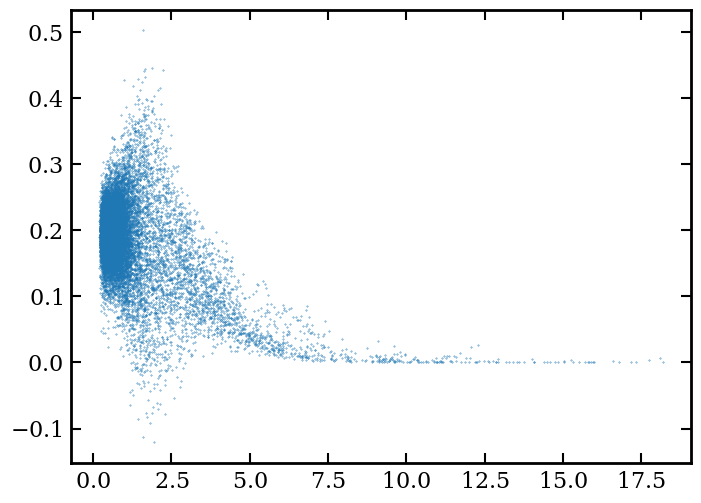

In [18]:
dist_test = np.sqrt(X_test[:,0]**2.0+X_test[:,1]**2.0+X_test[:,2]**2.0)

plt.scatter(train_dist[::10],pred_train,s=0.1)
plt.show()

plt.scatter(dist_test[::10],pred_test,s=0.1)
plt.show()